In [8]:
import os
import rf
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from math import ceil
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert, correlate


In [9]:
def apply_reverberation_filter(cha_data):
    result_stream = []
    for i, tr in enumerate(cha_data):
        lead_time = tr.stats.onset - tr.stats.starttime

        relative_time = tr.times() - lead_time
        mask = np.array((relative_time < 0) | (relative_time > 5.0))
        loc = np.argmax(np.ma.masked_array(tr.data, mask=mask))
        dt = relative_time[loc]

        data = correlate(tr.data, tr.data, mode='full')
        data /= np.max(data)
        data = data[len(data) // 2:]

        r0 = -(np.min(data))
        Dt = np.argmin(data) * 1. / tr.stats.sampling_rate

        tr_copy = tr.copy()
        resonance_filter = np.zeros(len(tr.data))
        resonance_filter[0] = 1
        resonance_filter[int(Dt * tr.stats.sampling_rate)] = r0
        tr_copy.data = np.convolve(tr_copy.data, resonance_filter, mode='full')
        tr_copy.data = tr_copy.data[:len(tr_copy.data) // 2 + 1]

        assert tr.data.shape == tr_copy.data.shape, 'Input/output length mismatch detected in ' \
                                                    'reverberation removal routine'

        tr_copy.stats.update({'t1_offset':dt,
                              't2_offset':Dt - dt,
                              't3_offset':Dt})

        result_stream.append(tr_copy)
    # end for

    return rf.RFStream(result_stream)

In [10]:
try:
    dataroot = os.environ["DATADIR"]
except KeyError:
    dataroot = os.path.join("..", "data", "processed")
try:
    run = os.environ['RUN']
except KeyError:
    print("Using latest run")
    run = max(
        [
            os.path.join(dataroot, d)
            for d in os.listdir(dataroot)
            if os.path.isdir(os.path.join(dataroot, d))
        ],
        key=os.path.getmtime,
    )
stacks = rf.read_rf(os.path.join(run, "rfstacks.h5"), format='h5').sort(["delay","network", "station"])
reverb_filter_stacks = apply_reverberation_filter(stacks)

Using latest run


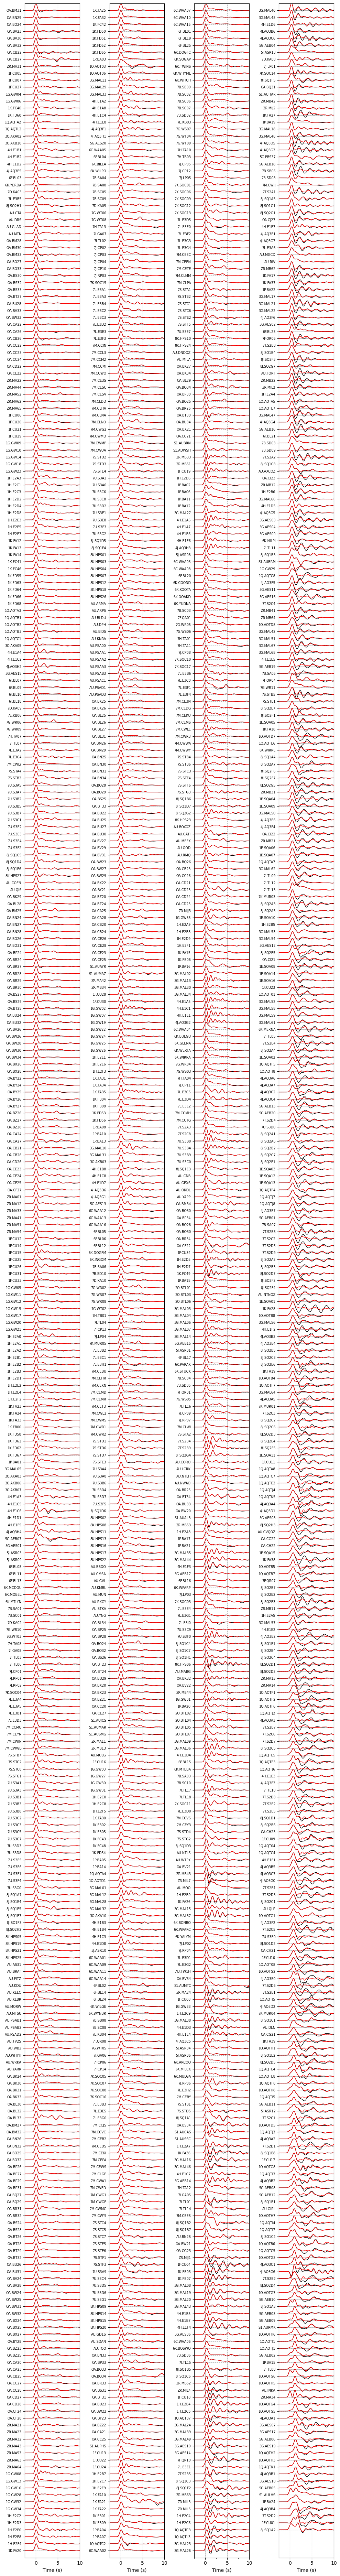

In [11]:
delays = [trace.stats.delay for trace in stacks]
nstacks = len(stacks)
ncols = 4
stacks_per_column = ceil(nstacks / ncols)

stack_height = 0.2
column_height = stack_height * stacks_per_column
fig, axs = plt.subplots(1, ncols, figsize=(10, column_height + 2), tight_layout=True)
for j, ax in enumerate(axs):
    i = 0
    column_stations = []
    while i < stacks_per_column:
        try:
            stack = stacks[j * stacks_per_column + i]
            rv_stack = reverb_filter_stacks[j * stacks_per_column + i]
            assert stack.id == rv_stack.id, f"Stack id {stack.id} does not match that from reverb_filter_stack {rv_stack.id}"
        except IndexError:
            # plot nothing so that what is plotted doesn't get stretched along y
            ax.plot(times, data + i, alpha=0)
            i += 1
            continue
        for _stack, style in zip([stack, rv_stack], ["k", "r"]):
            times = _stack.times() - _stack.stats.onset.second
            data = _stack.data
            data /= data.max()
            level = stacks_per_column - 1 - i
            ax.plot(times, data + level, style, lw=1)
        column_stations.append(".".join([_stack.meta.network, _stack.meta.station]))
        i += 1
    while i:
        try:
            ax.set_yticks(np.arange(stacks_per_column - 1, stacks_per_column - 1 - i, -1))
            ax.set_yticklabels(column_stations, fontsize="x-small", horizontalalignment="right")
        except ValueError:  # i != len(column_stations) 
            i -= 1
        else:
            break

for ax in axs:
    ax.xaxis.set_minor_locator(MultipleLocator(2.5))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.set_xlim([-2.5, 10])
    ax.set_ylim([-1, stacks_per_column])
    ax.grid(True, ls="--")
    ax.set_xlabel("Time (s)")


In [20]:
delays = []
Dts = []
for tr in reverb_filter_stacks:
    delays.append(tr.stats.delay)
    Dts.append(tr.stats.t3_offset)

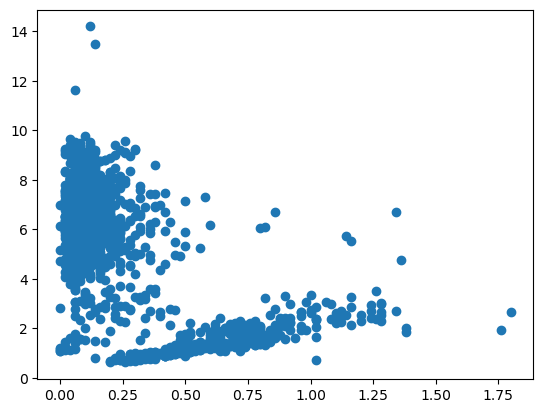

In [23]:
plt.scatter(delays, Dts)